In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import os,sys, gc
import matplotlib.pyplot as plt
from scipy.stats import entropy
!pip install --extra-index https://test.pypi.org/simple pandarallel topicpy
from topicpy.hsbmpy import get_max_available_L

os.environ["TF_CUDNN_USE_AUTOTUNE"]="0"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
algorithm = "topsbm"
directory='/content/drive/My Drive/phd/datasets/cancers/breast'
L = 0
os.chdir(directory)

In [ ]:
label = 'Subtype_Selected_Lum'

df_topics = pd.read_csv("topsbm_all/%s_level_%d_topic-dist.csv"%(algorithm,L)).set_index('doc').drop('i_doc', axis=1)
df_words = pd.read_csv("topsbm_all/%s_level_%d_word-dist.csv"%(algorithm,L), index_col=0)
df_words.index=[g[:15] for g in df_words.index]
df = pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index)
df = df.divide(df.sum(0),1).transpose().fillna(0)
df_files=pd.read_csv("files.dat", index_col=0)
df_topics.insert(0,'tissue', df_files.reindex(index=df_topics.index)[label])
df_topic_tissue = df_topics.groupby('tissue').mean()
df_files.head()

,cases.0.submitter_id,cases.0.diagnoses.0.primary_diagnosis,cases.0.diagnoses.0.morphology,cases.0.diagnoses.0.tissue_or_organ_of_origin,cases.0.diagnoses.0.tumor_grade,cases.0.diagnoses.0.tumor_stage,cases.0.project.disease_type,cases.0.project.primary_site,cases.0.samples.0.longest_dimension,Tumor.Type,Included_in_previous_marker_papers,vital_status,days_to_birth,days_to_death,days_to_last_followup,age_at_initial_pathologic_diagnosis,pathologic_stage,Tumor_Grade,BRCA_Pathology,BRCA_Subtype_PAM50,MSI_status,HPV_Status,tobacco_smoking_history,CNV Clusters,Mutation Clusters,DNA.Methylation Clusters,mRNA Clusters,miRNA Clusters,lncRNA Clusters,Protein Clusters,PARADIGM Clusters,Pan-Gyn Clusters,birth_year,death_year,age,age_binned,cancer.type,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected,Subtype_Selected_Lum
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87fcecde-b317-4518-bea1-cc8d14a18107.FPKM.txt.gz,TCGA-BH-A0W3,"Infiltrating duct carcinoma, NOS",8500/3,"Breast, NOS",not reported,stage iia,Breast Invasive Carcinoma,Breast,unknown,BRCA,YES,Alive,-21369.0,unknown,728.0,58.0,Stage_II,unknown,IDC,LumB,unknown,unknown,unknown,C3,C4,C1,C1,C3,unknown,unknown,C5,unknown,1961-11-05 12:43:40.592206,unknown,unknown,unknown,BRCA,LumB,unknown,unknown,unknown,unknown,unknown,unknown,BRCA.LumB,BRCA.Lum
bbf9a30d-3067-491b-9aea-0cb9bed91969.FPKM.txt.gz,TCGA-A8-A07F,"Infiltrating duct carcinoma, NOS",8500/3,"Breast, NOS",not reported,stage iib,Breast Invasive Carcinoma,Breast,unknown,BRCA,YES,Alive,-23742.0,unknown,577.0,65.0,Stage_II,unknown,Mixed,LumA,unknown,unknown,unknown,C5,C1,C1,C1,C3,C3,C2,C5,C1,1955-05-08 12:43:40.590999,unknown,unknown,unknown,BRCA,LumA,unknown,unknown,unknown,unknown,unknown,unknown,BRCA.LumA,BRCA.Lum
c909a75f-23e8-4c96-82f2-72e46fdb8155.FPKM.txt.gz,TCGA-GM-A3XL,"Infiltrating duct carcinoma, NOS",8500/3,"Breast, NOS",not reported,stage iia,Breast Invasive Carcinoma,Breast,unknown,BRCA,NO,Alive,-18171.0,unknown,2108.0,49.0,Stage_II,unknown,IDC,Basal,unknown,unknown,unknown,C4,C1,C4,C4,C7,unknown,C5,C4,C5,1970-08-08 12:43:40.593281,unknown,unknown,unknown,BRCA,Basal,unknown,unknown,unknown,unknown,unknown,unknown,BRCA.Basal,BRCA.Basal
1c89ff2f-6e0a-4244-952b-1391dba1b815.FPKM.txt.gz,TCGA-LL-A441,"Infiltrating duct carcinoma, NOS",8500/3,"Breast, NOS",not reported,stage ia,Breast Invasive Carcinoma,Breast,unknown,BRCA,NO,Alive,-22772.0,unknown,996.0,62.0,Stage_I,unknown,IDC,Normal,unknown,unknown,unknown,C4,C4,C4,C4,C7,unknown,C5,C4,C3,1958-01-02 12:43:40.593313,unknown,unknown,unknown,BRCA,Normal,unknown,unknown,unknown,unknown,unknown,unknown,BRCA.Normal,BRCA.Normal
2a6ae2e8-733f-4349-8eec-d25e2b4abf86.FPKM.txt.gz,TCGA-BH-A0HP,"Lobular carcinoma, NOS",8520/3,"Breast, NOS",not reported,stage iiia,Breast Invasive Carcinoma,Breast,unknown,BRCA,YES,Alive,-23883.0,unknown,414.0,65.0,Stage_III,unknown,ILC,LumA,unknown,unknown,unknown,C1,C9,C1,C1,C3,C2,C1,C6,C1,1954-12-18 12:43:40.592189,unknown,unknown,unknown,BRCA,LumA,unknown,unknown,unknown,unknown,unknown,unknown,BRCA.LumA,BRCA.Lum


## NN based predictor

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error, categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.python.client.device_lib import list_local_devices
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os,sys, gc
list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7241674767590229235, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17545716260107832569
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16920993901823353750
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14648777152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17248284766432224415
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
def preprocess_data(verbose=True):
  global df_topics
  global df_files
  df_topics = df_topics[df_topics["tissue"]!="unknown"]

  df_labels=df_files.copy()
  df_labels=df_labels.reindex(index=df_topics.index)

  uniq = len(df_labels[label].unique())

  X = df_topics.drop('tissue',1)
  X = X.subtract(X.mean(0),1).divide(0.5*(X.max(0)-X.min(0)),1).values.astype(float) #SGD transform
  Y = to_categorical(np.unique(df_labels[label], return_inverse=True)[1])
  inputs = X.shape[1]

  classes=np.unique(df_labels[df_labels.index.isin(df.index)][label], return_inverse=True)[0]

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, random_state=42, train_size=0.9)

  if verbose:
    print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
  return inputs, uniq, df_labels, X_train, X_test, Y_train, Y_test

In [ ]:
inputs, uniq, df_labels, X_train, X_test, Y_train, Y_test = preprocess_data(True)

(1084, 399) (1084, 4) (121, 399) (121, 4)


In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

class KNNClassifier(KNeighborsClassifier):
    def __init__(self, n_neighbors=10, **kwargs):
        super().__init__(n_neighbors, **kwargs)

    def fit(self,  X, y):
        return super().fit(X, y)

    def evaluate(self, X, Y):
        Y_pred = self.predict(X)
        if tf.cast(tf.round(tf.reduce_max(Y)),tf.int64) > tf.constant(1, dtype=tf.int64):
            Y = to_categorical(Y)
            Y_pred = to_categorical(Y_pred)
        acc = accuracy_score(Y, Y_pred)
        auc = roc_auc_score(Y, Y_pred, average="weighted", multi_class="ovr")
        print(f"Accuracy: {acc}, AUC:{auc}")
        return [acc, auc]

def fit_knn(X_knn_train, X_knn_test, Y_knn_train, Y_knn_test):
    X_pj_train, X_pj_test, Y_pj_train, Y_pj_test = list(map(tf.convert_to_tensor, (X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)))
    print(uniq, X_knn_train.shape, Y_knn_train.shape, X_knn_test.shape, Y_knn_test.shape, Y_knn_train[0])
    import time
    with tf.device("GPU"):
        model_knn = KNNClassifier(n_neighbors=5, n_jobs=4, metric="euclidean")
        model_knn.fit(X_knn_train, Y_knn_train)
        model_knn.evaluate(X_knn_test, Y_knn_test)

X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index).fillna(0).values.T, to_categorical(np.unique(df_files.reindex(index=df.index)[label], return_inverse=True)[1]), random_state=42, train_size=0.8)
fit_knn(X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)

X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index).fillna(0).applymap(lambda tpm: np.log2(tpm+1)).values.T, np.unique(df_files.reindex(index=df.index)[label], return_inverse=True)[1], random_state=42, train_size=0.8)
fit_knn(X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)

X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(X_train, Y_train, random_state=42, train_size=0.8)
fit_knn(X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)

model_knn = KNNClassifier(n_neighbors=5, n_jobs=4, metric="euclidean")
model_knn.fit(X_knn_train, Y_knn_train)
model_knn.evaluate(X_knn_test, Y_knn_test)


4 (977, 977) (977, 5) (245, 977) (245, 5) [1. 0. 0. 0. 0.]
Accuracy: 0.8081632653061225, AUC:0.8091719775370633
4 (977, 977) (977,) (245, 977) (245,) 0
Accuracy: 0.9306122448979591, AUC:0.9193730574421551
4 (867, 399) (867, 4) (217, 399) (217, 4) [0. 0. 1. 0.]
Accuracy: 0.9170506912442397, AUC:0.9040875008844115
Accuracy: 0.9170506912442397, AUC:0.9040875008844115


[0.9170506912442397, 0.9040875008844115]

In [ ]:
def create_model(opt, l1, l2, hidden, loss=categorical_crossentropy, activation_func = "softmax",  verbose=True):
  K.clear_session()

  inputs, uniq, df_labels, X_train, X_test, Y_train, Y_test = preprocess_data(verbose)

  os.system("rm -rf log.csv")
  model=Sequential()
  model.add(Dense(units=hidden, input_dim=inputs, use_bias=True, bias_initializer="ones", activation="relu", kernel_regularizer=l1_l2(l1=l1, l2=l2)))
  model.add(Dense(units=uniq, activation=activation_func))
  model.compile(loss=loss, optimizer=opt, metrics=['accuracy', 'AUC', f1])
  K.set_learning_phase(0)

  if verbose:
    print(model.summary())
    plot_model(model, to_file=f"model_{label}.png", dpi=600, show_shapes=True)
  return model, X_train, X_test, Y_train, Y_test 

In [ ]:
def train_GS():
  csv_logger = CSVLogger('log.csv', append=True, separator=',')
  es = EarlyStopping(monitor='val_loss', min_delta=1e-3, mode='min', patience=25)

  momentum = 0.95
  best_model = None
  best_score = -np.inf
  for lr in [0.001, 0.0003]:
    for l1 in [0.001,0.0001]:
      for l2 in [0.001, 0.0001]:
        for bs in [50,100]:
          for momentum in [0.95, 0.98, 0.99]:
            for hidden in [50, 75, 100]:
              print(lr, l1, l2, bs, momentum, hidden)
              opt = SGD(lr=lr, momentum=momentum)
              model, X_train, X_test, Y_train, Y_test  = create_model(opt, l1, l2, hidden, verbose=False)
              with tf.device("GPU"):
                hist = model.fit(X_train, Y_train, epochs=500, batch_size=bs, verbose=0, validation_split=0.8, callbacks=[csv_logger, es], shuffle=True, use_multiprocessing=True, workers=-1)
              f1_score = hist.history["val_f1"][-1]
              if f1_score > best_score:
                loss = hist.history["val_loss"][-1]
                acc = hist.history["val_accuracy"][-1]
                auc = hist.history["val_auc"][-1]
                print(f"loss: {loss}, accuracy: {acc}, AUC: {auc}, f1: {f1_score}")
                best_score = f1_score
                best_model=model
  return best_model, lr, l1, l2, bs, momentum, hidden

#model, lr, l1, l2, bs, momentum, hidden = train_GS()
#print(lr, l1, l2, bs, momentum, hidden)

In [ ]:
#L=1 Lum
#model, X_train, X_test, Y_train, Y_test = create_model(SGD(0.001, momentum=0.95), l1=0.001, l2=0.01, hidden=75, loss=categorical_crossentropy, activation_func = "softmax",  verbose=True)
#hist = model.fit(X_train, Y_train, epochs=500, batch_size=50, verbose=1, validation_split=0.8, callbacks=[CSVLogger('log.csv', append=True, separator=','), EarlyStopping(monitor='val_loss', min_delta=1e-3, mode='min', patience=25)], shuffle=True, use_multiprocessing=True, workers=-1)

#L=0 Lum
with tf.device("GPU"):
    model, X_train, X_test, Y_train, Y_test = create_model(SGD(0.001, momentum=0.99), l1=0.0001, l2=0.0001, hidden=50, loss=categorical_crossentropy, activation_func = "softmax",  verbose=True)
    hist = model.fit(X_train, Y_train, epochs=500, batch_size=50, verbose=1, validation_split=0.8, callbacks=[CSVLogger('log.csv', append=True, separator=','), EarlyStopping(monitor='val_loss', min_delta=1e-3, mode='min', patience=25)], shuffle=True, use_multiprocessing=True, workers=-1)
    hist = model.fit(X_train, Y_train, epochs=500, batch_size=50, verbose=1, validation_split=0.8, callbacks=[CSVLogger('log.csv', append=True, separator=','), EarlyStopping(monitor='val_loss', min_delta=1e-3, mode='min', patience=15)], shuffle=True, use_multiprocessing=True, workers=-1)

#L=0
#model, X_train, X_test, Y_train, Y_test = create_model(SGD(0.003, momentum=0.99), l1=1e-1, l2=5e-3, hidden=100, loss=categorical_crossentropy, activation_func = "softmax",  verbose=True)
#hist = model.fit(X_train, Y_train, epochs=500, batch_size=100, verbose=1, validation_split=0.8, callbacks=[CSVLogger('log.csv', append=True, separator=','), EarlyStopping(monitor='val_loss', min_delta=1e-5, mode='min', patience=100)], shuffle=True, use_multiprocessing=True, workers=-1)

(1084, 399) (1084, 4) (121, 399) (121, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                20000     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 20,204
Trainable params: 20,204
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
5/5 [==============================] - 0s 96ms/step - loss: 1.9837 - accuracy: 0.0926 - auc: 0.4013 - f1: 0.0425 - val_loss: 1.8074 - val_accuracy: 0.1141 - val_auc: 0.4420 - val_f1: 0.0375
Epoch 2/500
5/5 [==============================] - 0s 26ms/step - loss: 1.5058 - accuracy: 0.3102 - auc: 0.6091 - f1: 0.1834 - val_loss: 1.1970 - val_accuracy: 0.5726 - val_auc: 0.7978 - val_f1: 0.4132
Epoch 3/500
5/5 [==============================] - 0s 28ms/step

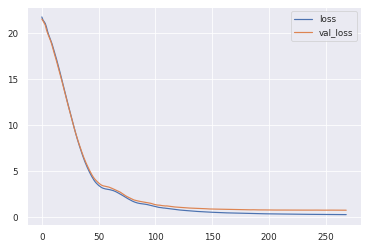

In [ ]:
pd.read_csv("log.csv", sep=",")[['loss','val_loss']].plot()

In [ ]:
model.evaluate(X_test, Y_test)

4/4 [==============================] - 0s 4ms/step - loss: 0.5252 - accuracy: 0.9008 - auc: 0.9798 - f1: 0.9062


[0.5251613259315491,
 0.9008264541625977,
 0.9797828197479248,
 0.9062499403953552]

In [ ]:
#model.save(f"model_{label}_{L}.h5")
model = load_model(f"model_{label}_{L}.h5", custom_objects={'f1': f1})
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                20000     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 20,204
Trainable params: 20,204
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gc.collect()

22

# evaluate on test set


In [ ]:
classes = df_labels[label].unique()
np.savetxt("classes.txt", classes, fmt="%s")
np.savetxt("X_test.txt", X_test)
np.savetxt("Y_test.txt", Y_test)
print(X_test.shape, Y_test.shape)

(121, 399) (121, 4)


In [ ]:
model.evaluate(X_test, Y_test, verbose=2, workers=-1, use_multiprocessing=True)

4/4 - 0s - loss: 0.5252 - accuracy: 0.9008 - auc: 0.9798 - f1: 0.9062


[0.5251613259315491,
 0.9008264541625977,
 0.9797828197479248,
 0.9062499403953552]

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

In [ ]:
y_pred_p = model.predict(X_test)
y_true = np.argmax(Y_test, axis=1)
y_pred = np.argmax(y_pred_p, axis=1)
results = confusion_matrix(y_true, y_pred, normalize="true")

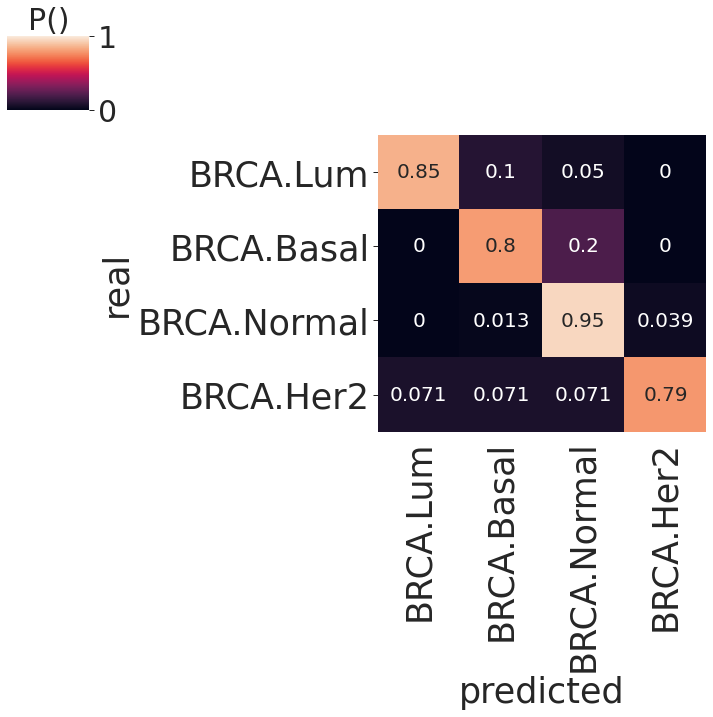

In [ ]:
cm = sns.clustermap(results, 
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=False, 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    annot=False,
                    annot_kws={"fontsize":20})
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("real", fontsize=35, rotation=90)
ax.set_yticklabels(labels=classes, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=classes, rotation=90)
ax.set_xlabel("predicted",fontsize=35)
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("P()", fontsize=30)
plt.tight_layout()
cm.savefig(f"predict_{label}.pdf")

plt.show()

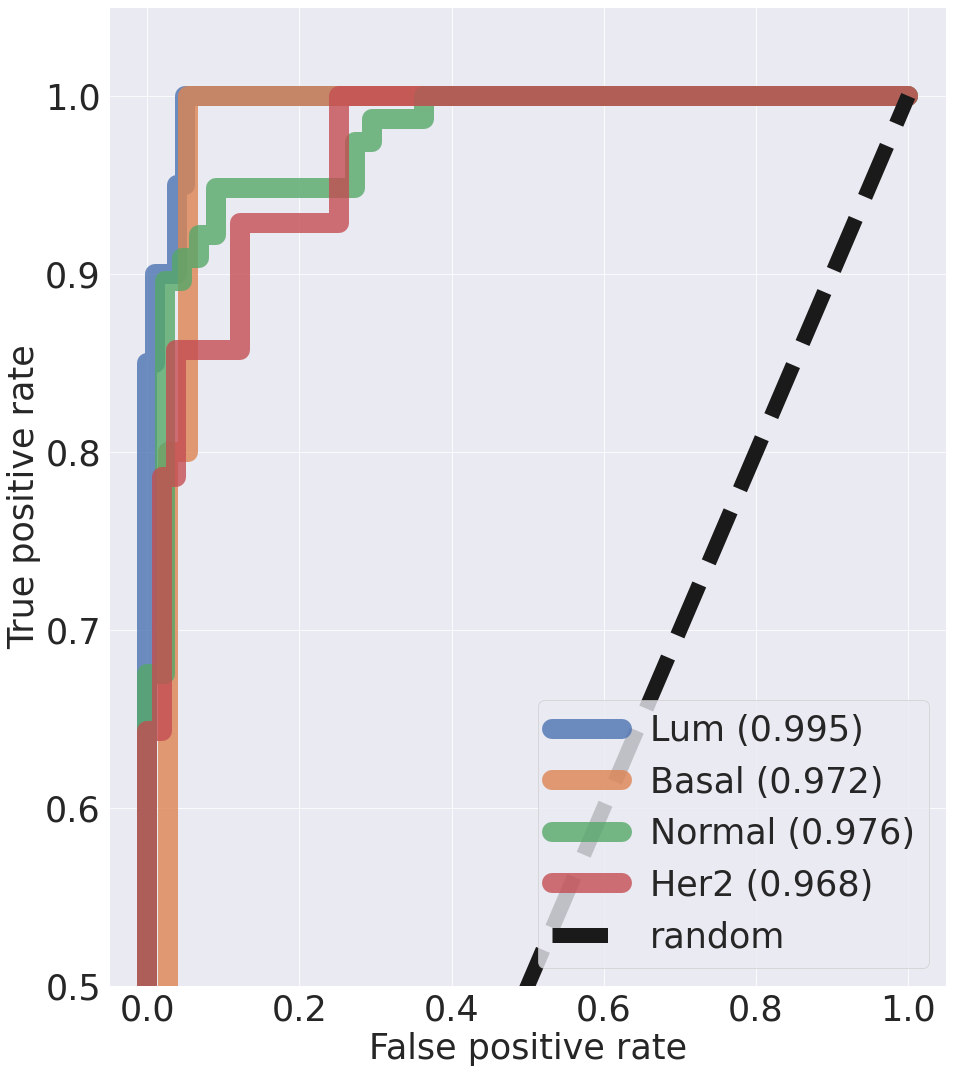

In [ ]:
fig, ax = plt.subplots(figsize=(15,18))
for itissue, tissue in enumerate(classes):
  tissue_true = y_true.copy()
  tissue_true[y_true==itissue]=1
  tissue_true[y_true!=itissue]=0
  fpr, tpr, thresholds = roc_curve(tissue_true, y_pred_p.T[itissue])
  score = roc_auc_score(tissue_true, y_pred_p.T[itissue])

  ax.plot(fpr,tpr, lw=20, alpha=0.8, label=tissue.replace("BRCA.","")+" (%.3f)"%score)

  ax.set_xlabel('False positive rate', fontsize=35)
  ax.set_ylabel('True positive rate', fontsize=35)

  ax.tick_params(labelsize=35)

ax.plot([0, 1], [0, 1], 'k--', lw=15, label="random")
ax.legend(fontsize=35)
ax.set_ylim(0.5,1.05)
plt.show()
fig.savefig(f"roc_{label}.pdf")